In [1]:
import gym
import pickle
import numpy as np
import matplotlib.pyplot as plt

from sklearn.utils import shuffle
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

from matplotlib import animation
from JSAnimation.IPython_display import display_animation
from IPython.display import display
%matplotlib inline

def display_frames_as_gif(frames):
    patch = plt.imshow(frames[0])
    plt.axis('off')
    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames =len(frames), interval=5)
    display(display_animation(anim, default_mode='loop'))

# Behavior Clonning 

# Pendulum Example

### Load data from pickle file

Data file has (s,a) pairs

In [2]:
envname = "Pendulum-v0"

# Load demonstrations
demo_file = open('./'+envname+'_expert_demo.pkl', 'rb')
demonstrations = pickle.load(demo_file)
demonstrations = shuffle(demonstrations)

# Check expert's performance
exp_ret = np.mean([np.sum(d['rewards']) for d in demonstrations])
print('Expert\'s Average Cumulative Rewards {:.3f}'.format(exp_ret))

demo_observes = []
demo_actions = []
for demonstration in demonstrations:
    for obs in demonstration['observes']:
        demo_observes.append(obs)
    for act in demonstration['actions']:
        demo_actions.append(act)
demo_observes=np.asarray(demo_observes)
demo_actions=np.asarray(demo_actions)

demo_observes, demo_actions = shuffle(demo_observes, demo_actions)

demo_observes = demo_observes[:500, :]
demo_actions = demo_actions[:500, :]

Expert's Average Cumulative Rewards -79.331


### Print the shape of data
### Find observation dimension and action dimension

In [3]:
obs_dim = (500, 3)
act_dim = (500, 1)

print("Observation data has shape {}".format(demo_observes.shape))
print("Action data has shape {}".format(demo_actions.shape))

Observation data has shape (500, 3)
Action data has shape (500, 1)


### Run Gaussian Process Regression

In [4]:
kernel = C(1.0, (1e-3, 1e3)) * RBF(1e4, (1e-2, 1e6))
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=5)

demo_obs_mean = np.mean(demo_observes,axis=0, keepdims=True)
demo_obs_std = np.std(demo_observes,axis=0, keepdims=True)
nz_demo_observes = (demo_observes - demo_obs_mean) / demo_obs_std

gpr = gp.fit(nz_demo_observes, demo_actions)

/home/pil-kso/anaconda3/envs/deep-learning-19/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([  31.68572948, -137.94928983]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 87, 'nit': 3, 'warnflag': 2}
  ConvergenceWarning)
/home/pil-kso/anaconda3/envs/deep-learning-19/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([  44.89687142, -201.22935556]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 96, 'nit': 5, 'warnflag': 2}
  ConvergenceWarning)
/home/pil-kso/anaconda3/envs/deep-learning-19/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([  65.99887802, -229.97571576]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 53, 'nit': 2, 'warnflag': 2}
  Conver

### Test GPR controller!

[2020-03-29 21:00:00,478] Making new env: Pendulum-v0
/home/pil-kso/anaconda3/envs/deep-learning-19/lib/python3.6/site-packages/gym/envs/registration.py:17: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


Total Reward : -4.43



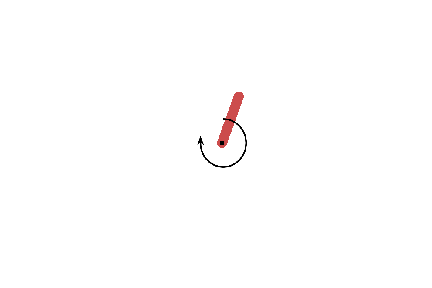
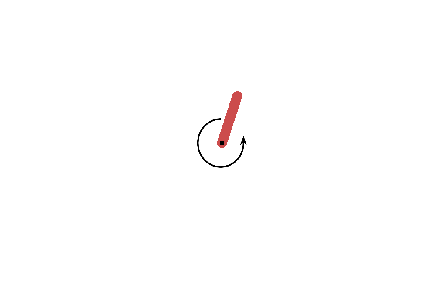
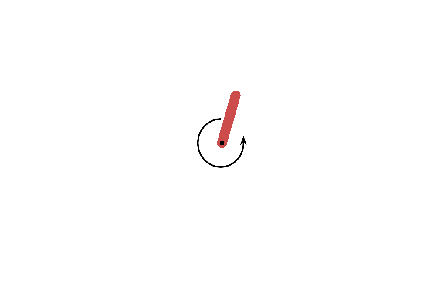
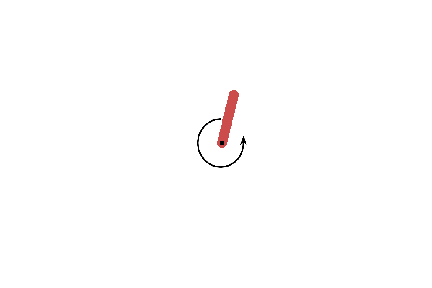
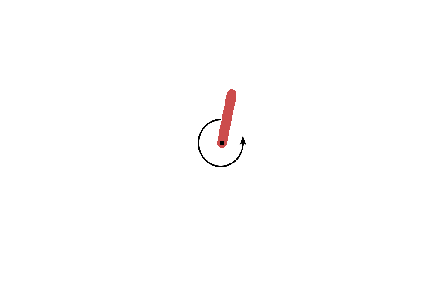
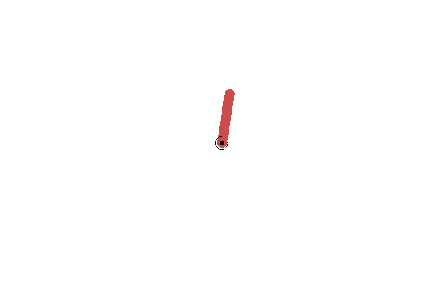
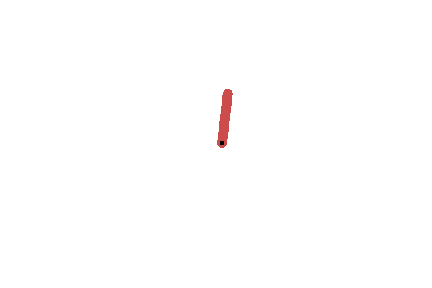
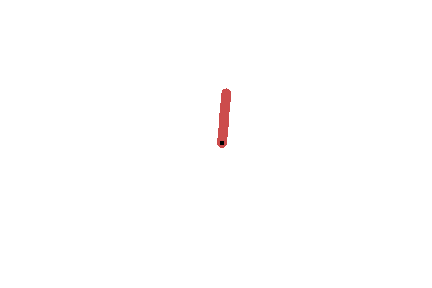
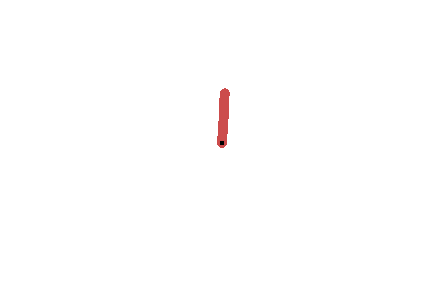
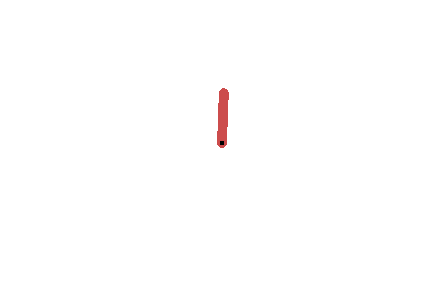
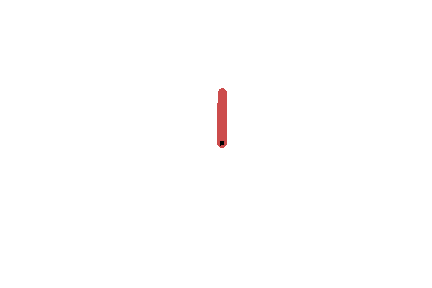
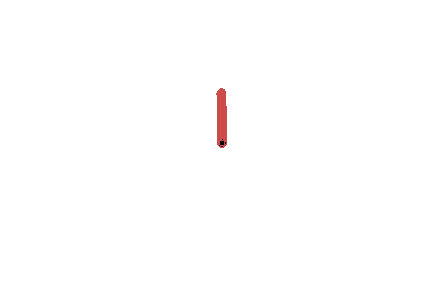
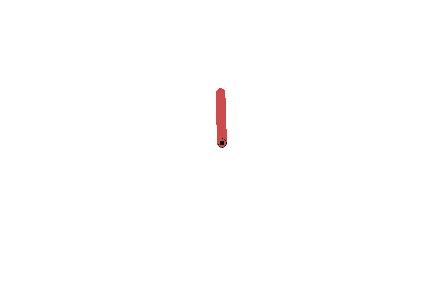
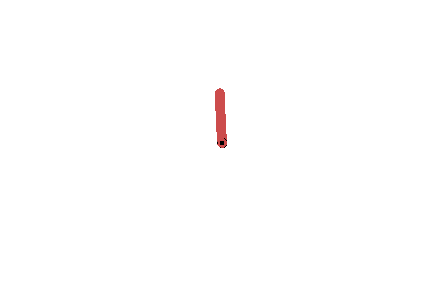
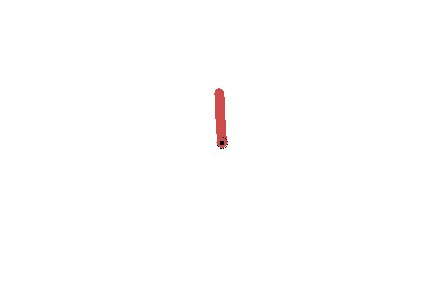
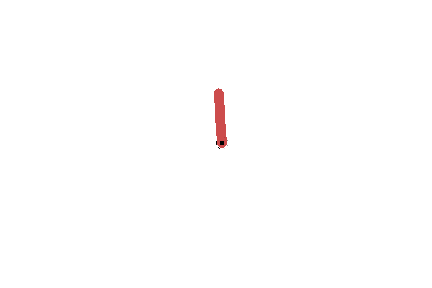
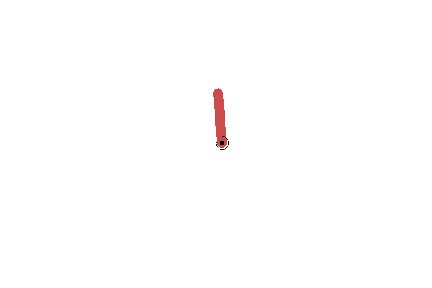
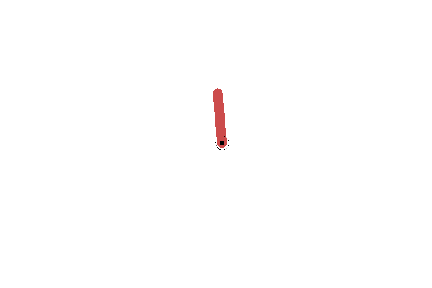
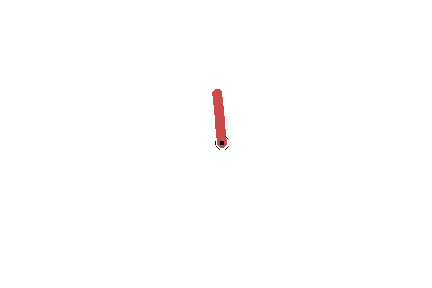
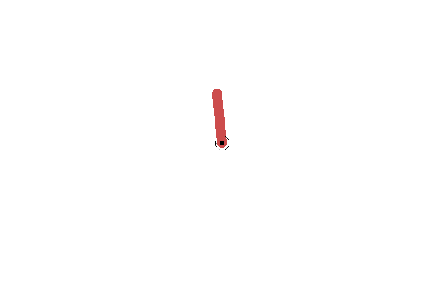
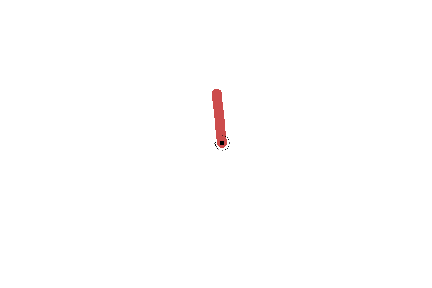
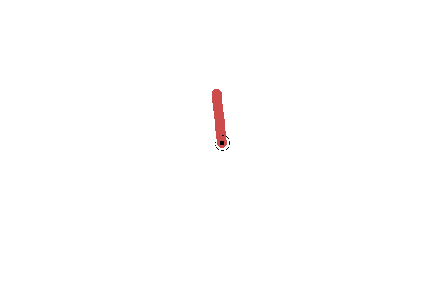
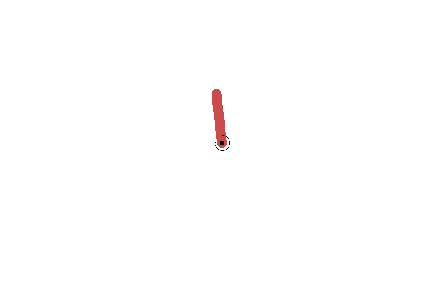
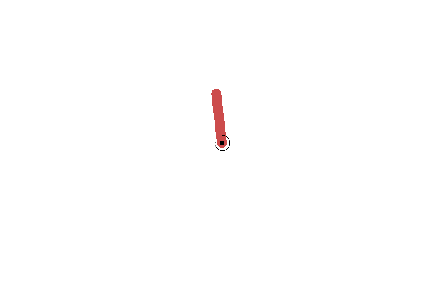
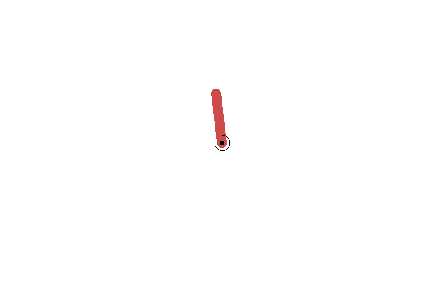
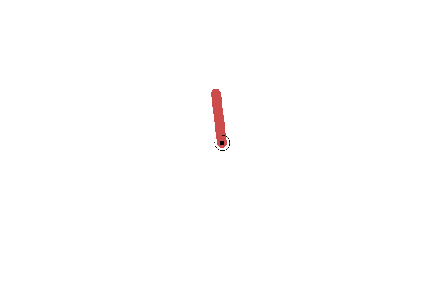
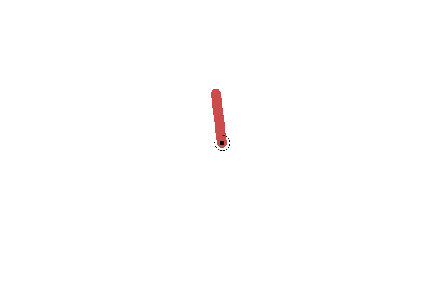
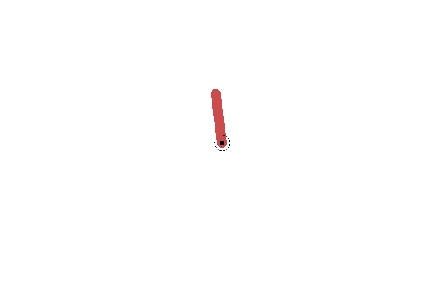
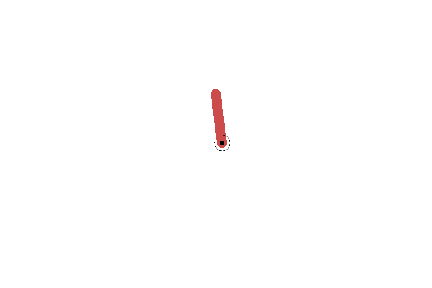
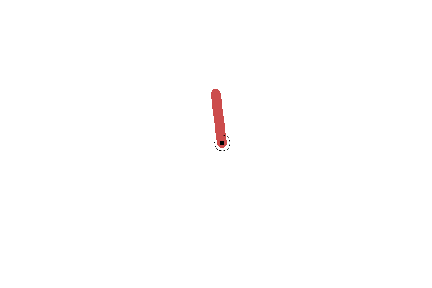
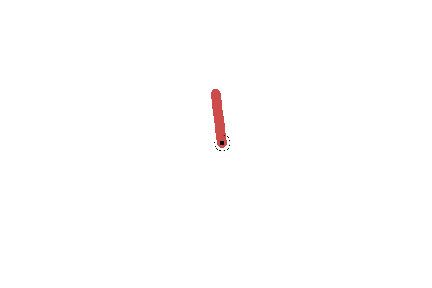
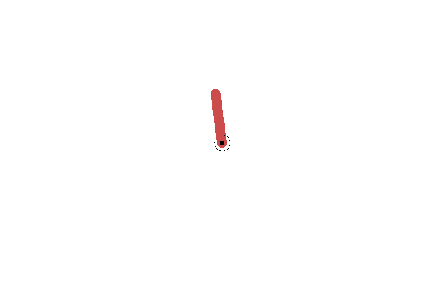
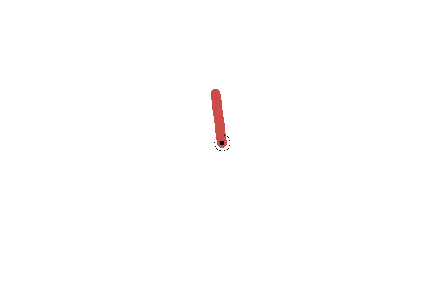
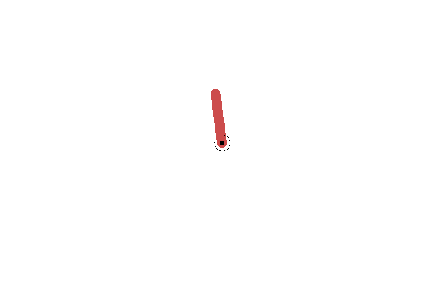
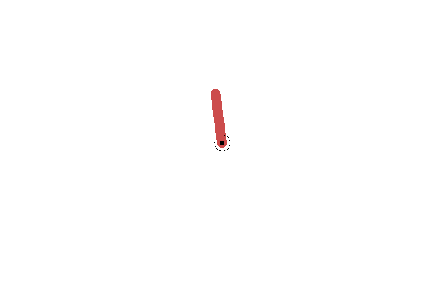
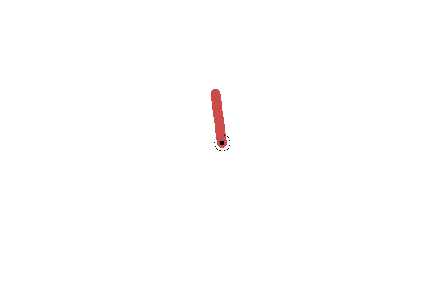
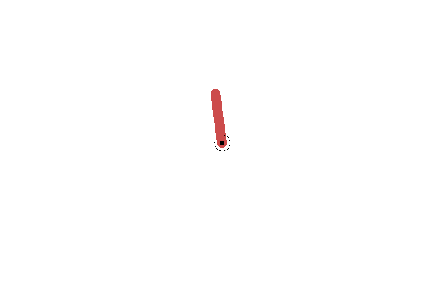
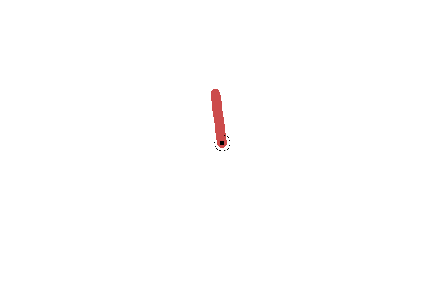
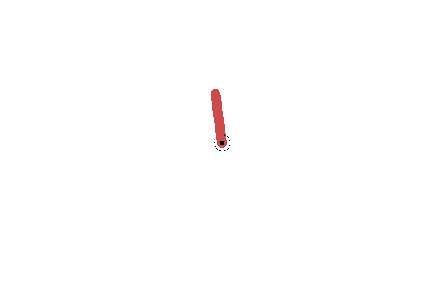
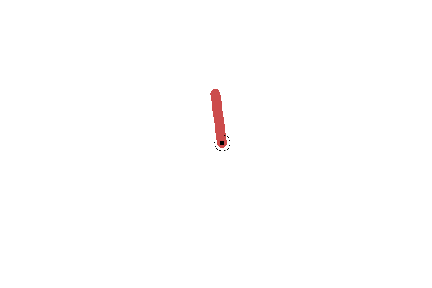
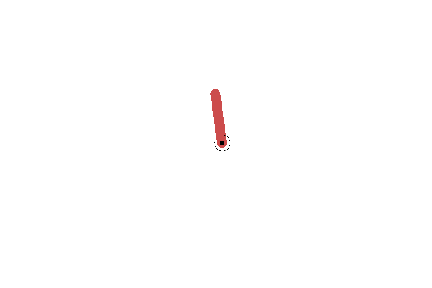
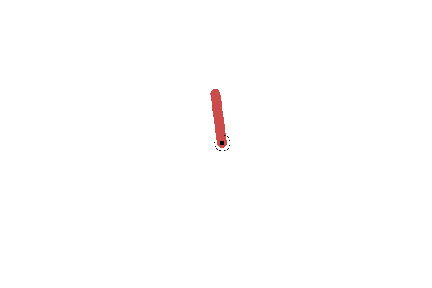
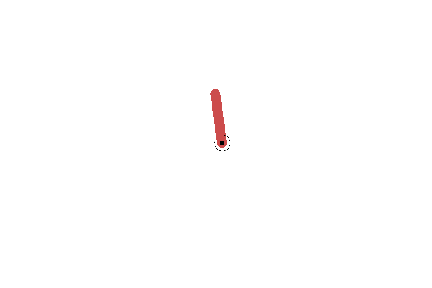
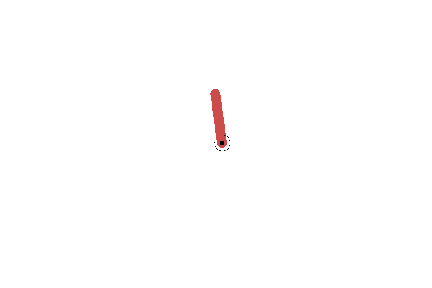
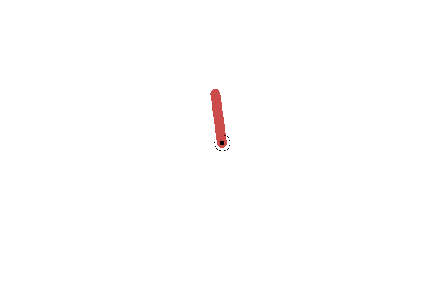
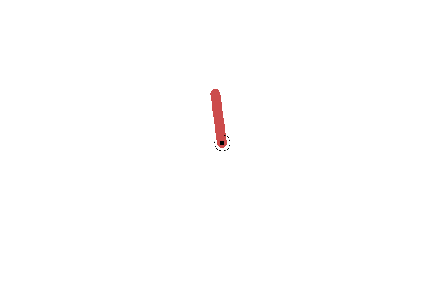
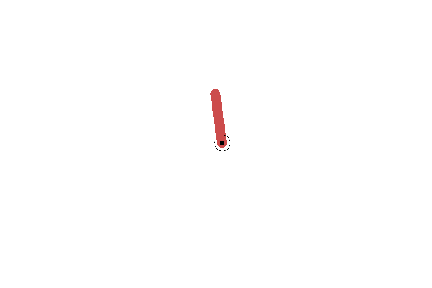
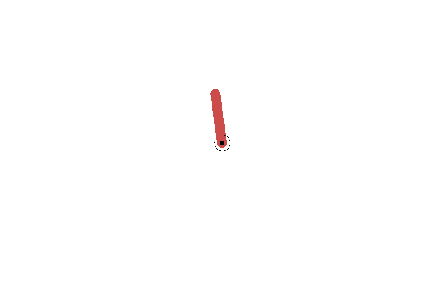
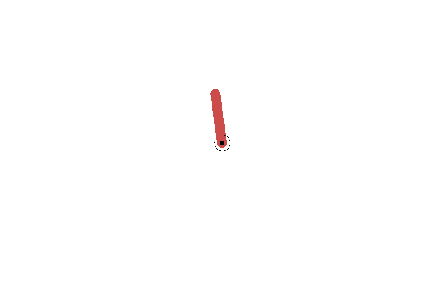
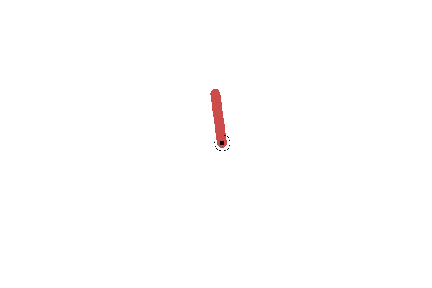
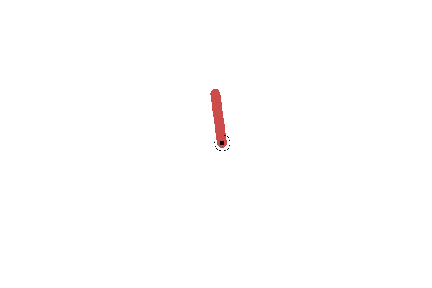
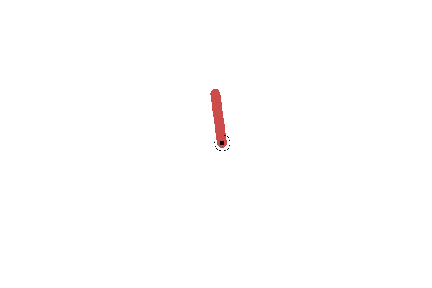
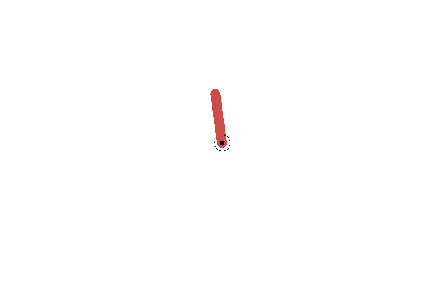
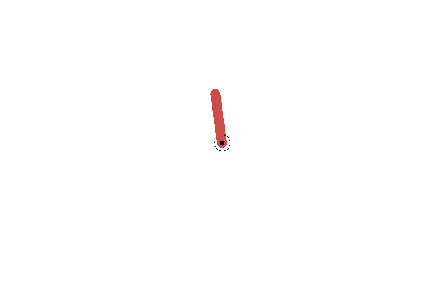
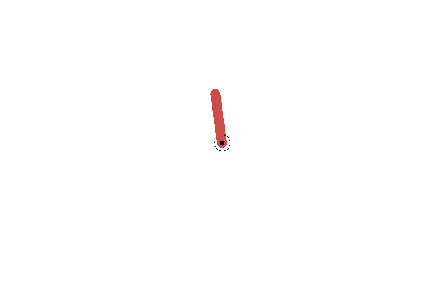
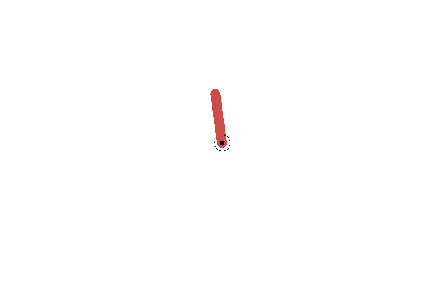
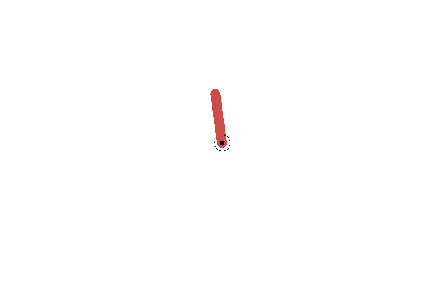
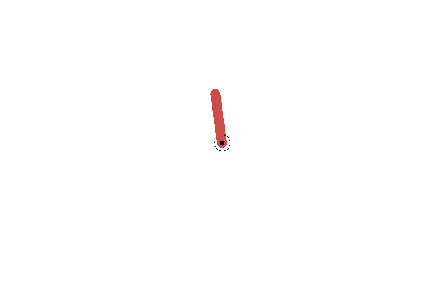
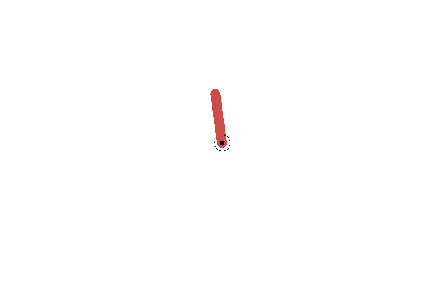
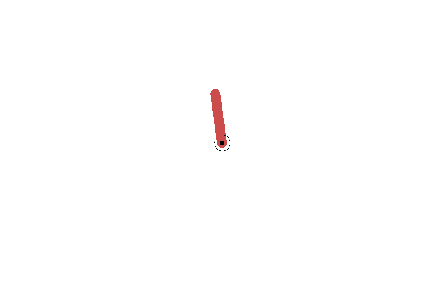
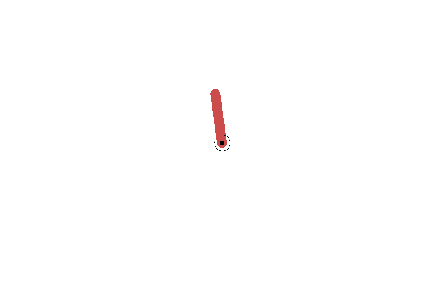
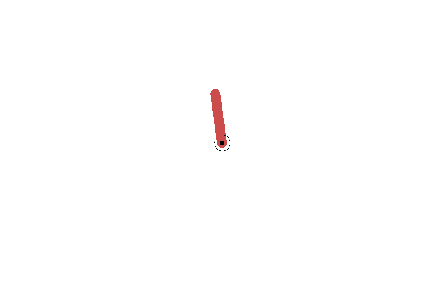
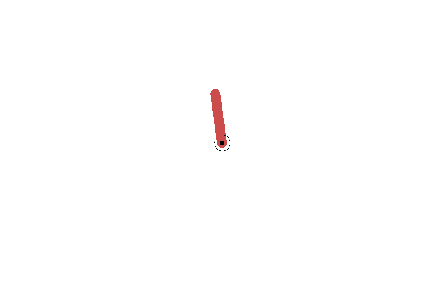
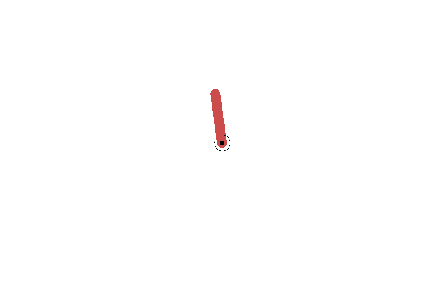
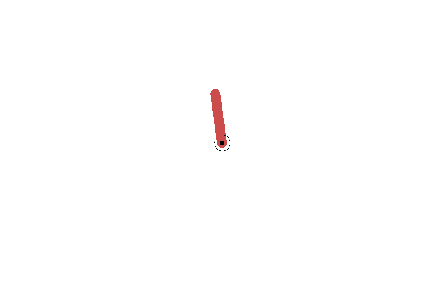
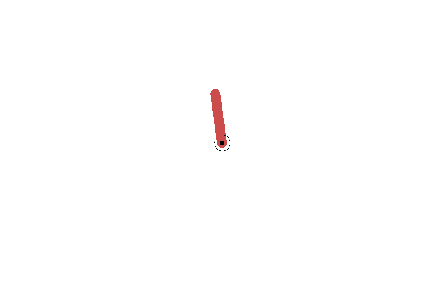
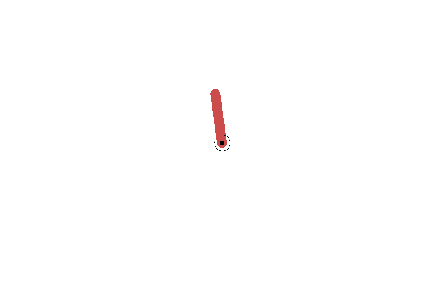
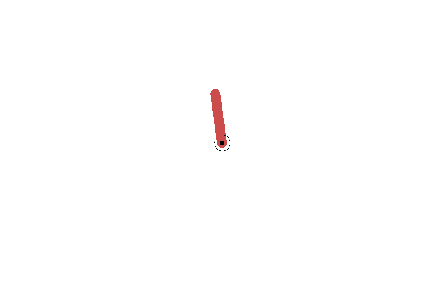
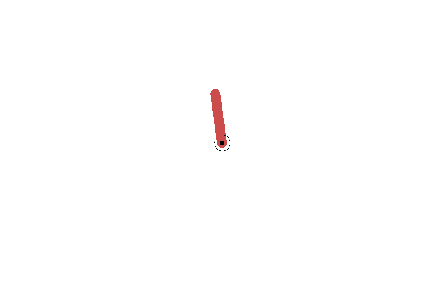
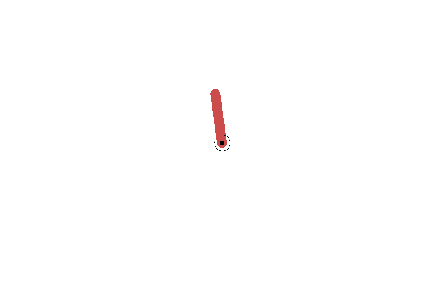
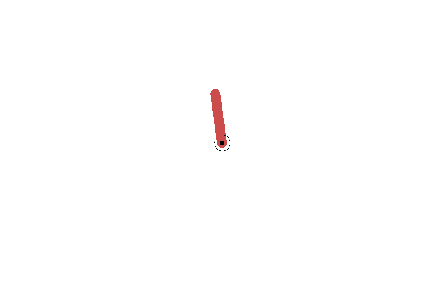
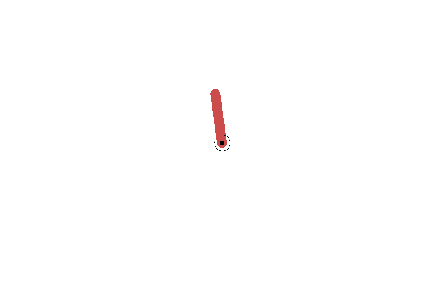
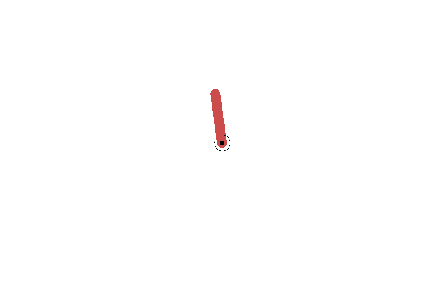
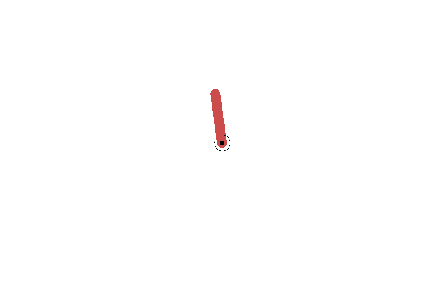
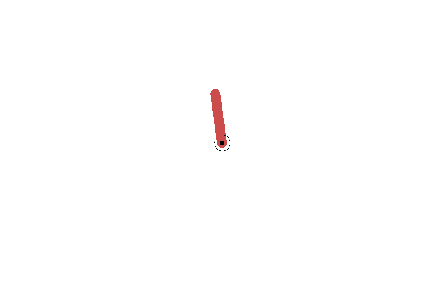
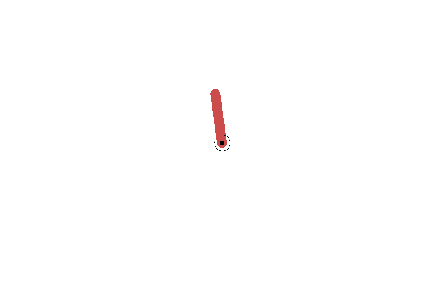
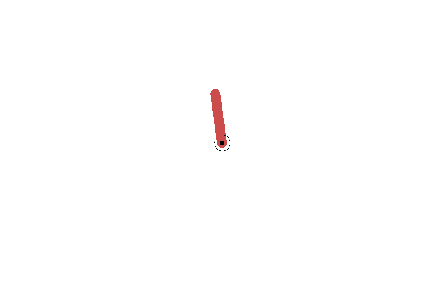
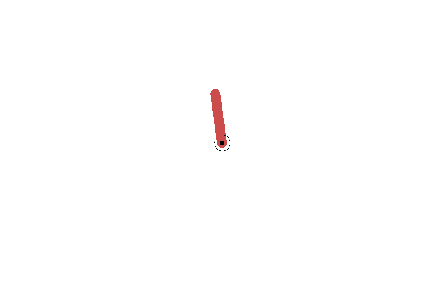
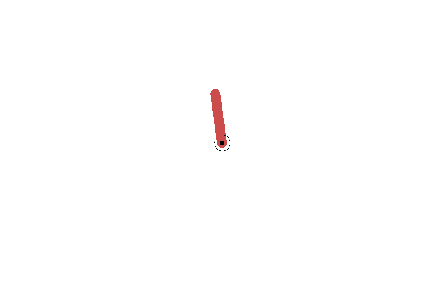
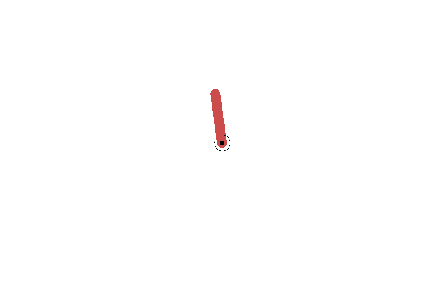
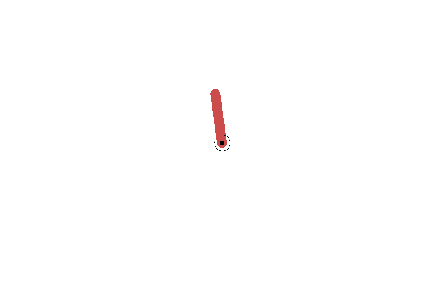
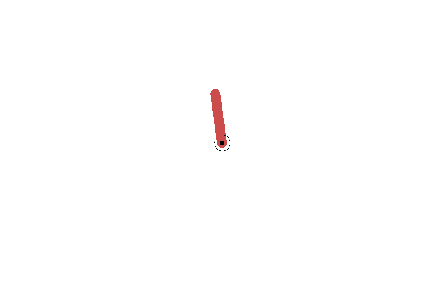
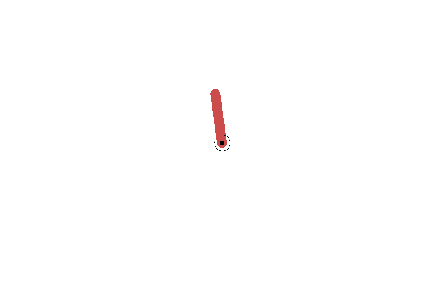
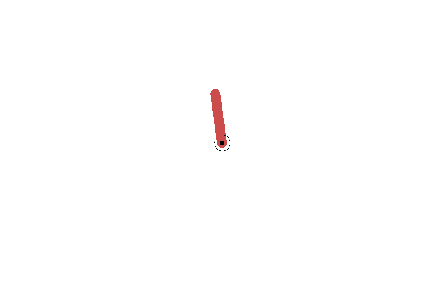
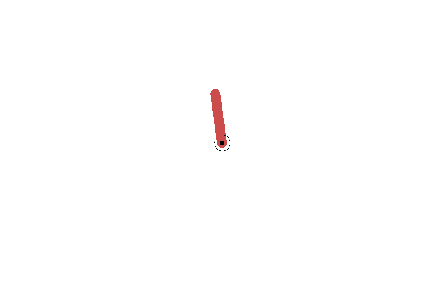
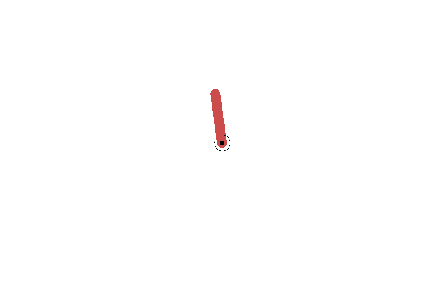
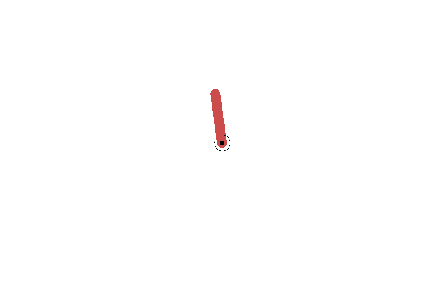
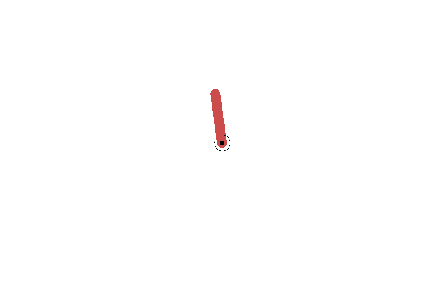
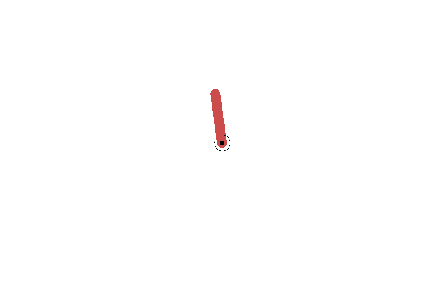
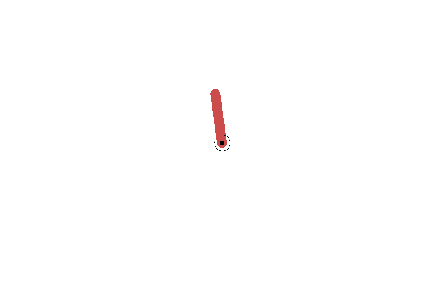
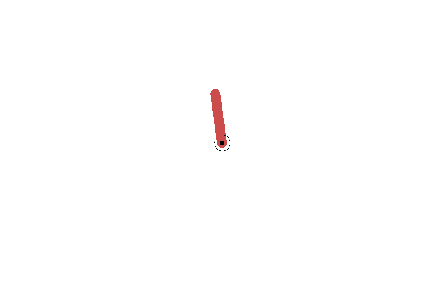
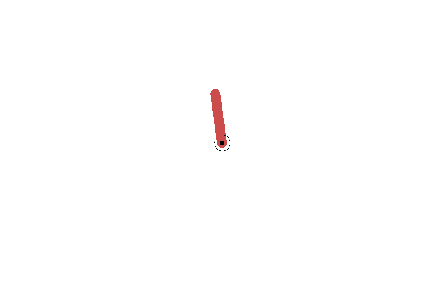
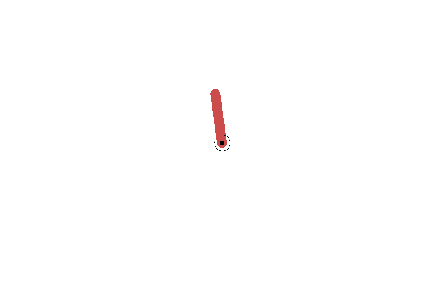
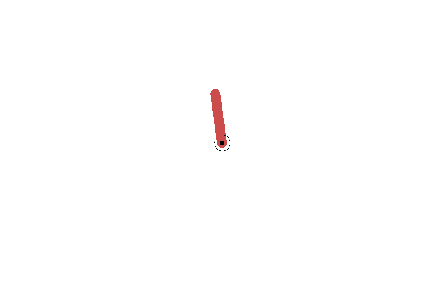
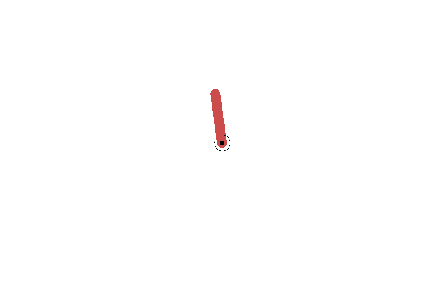
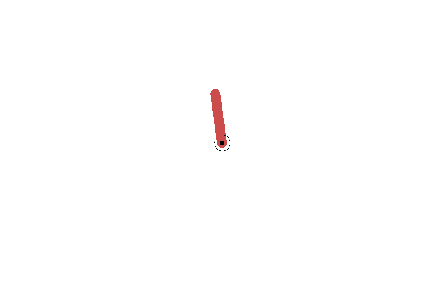
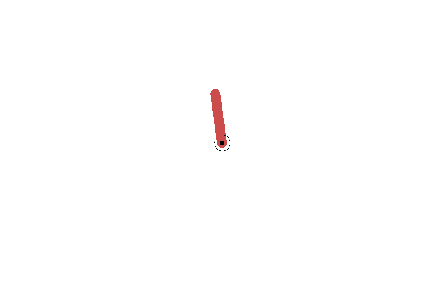
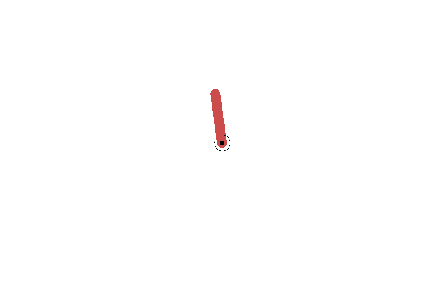
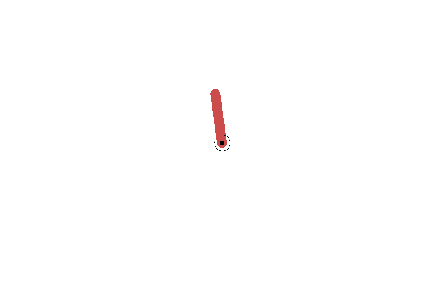
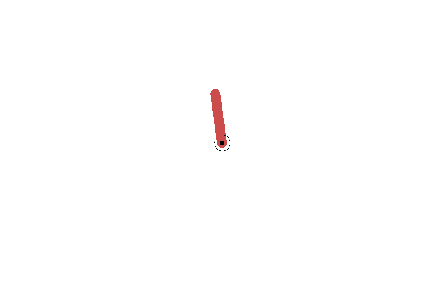
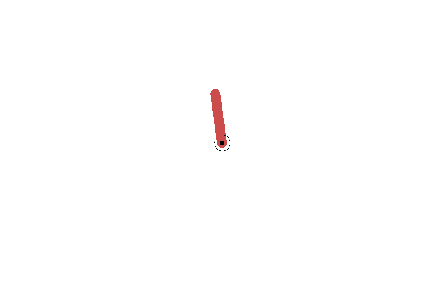
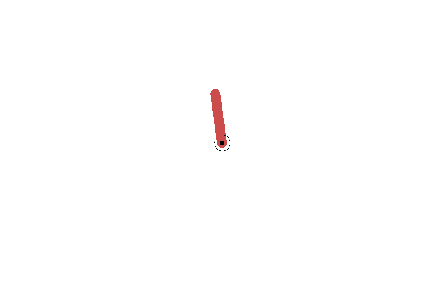
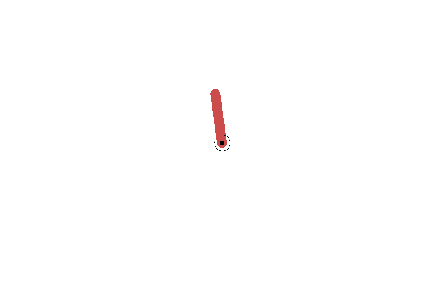
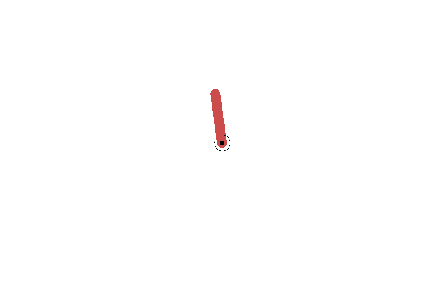
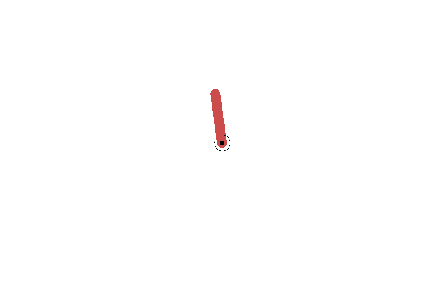
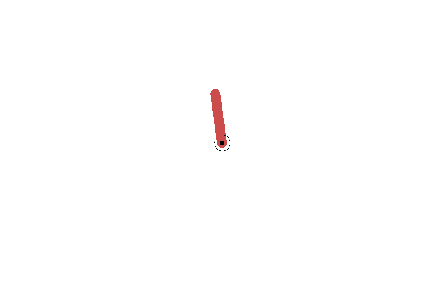
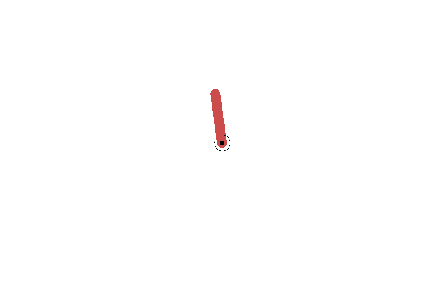
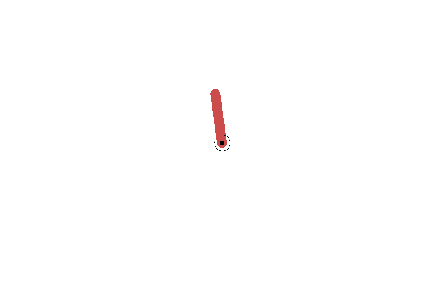
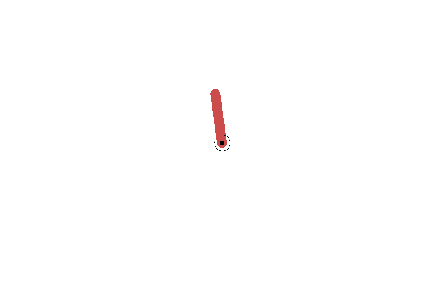
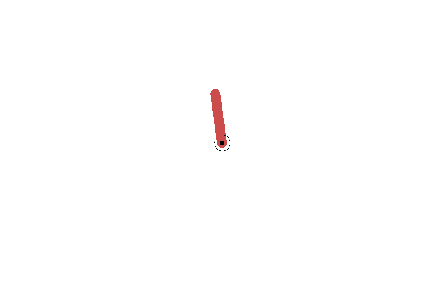
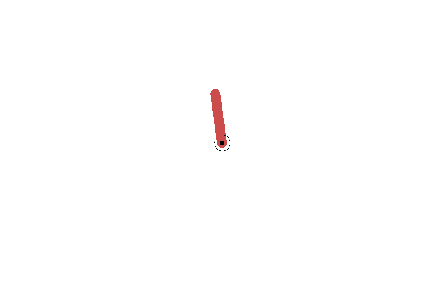
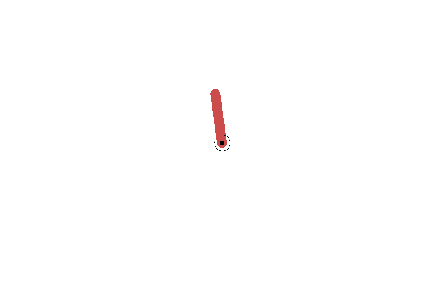
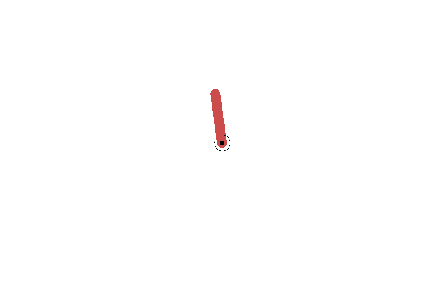
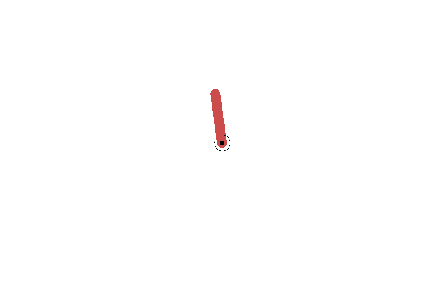
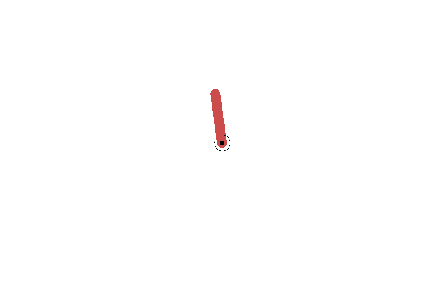
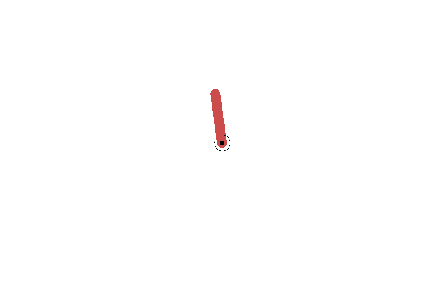
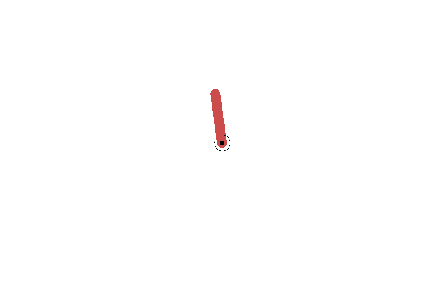
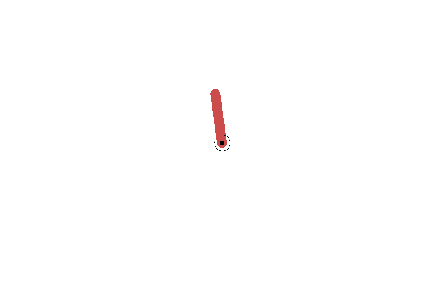
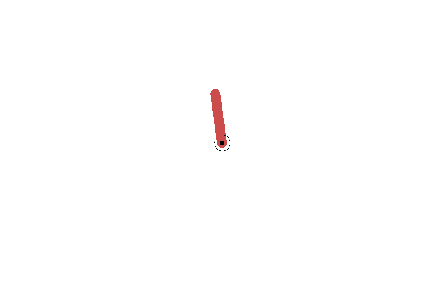
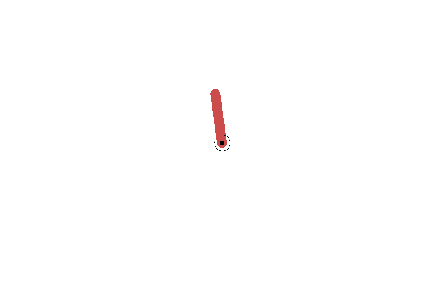
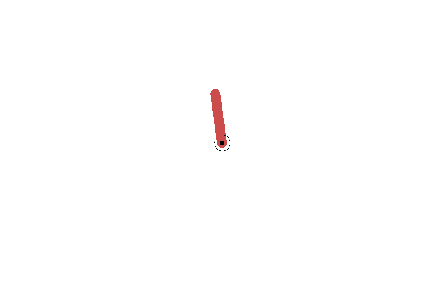
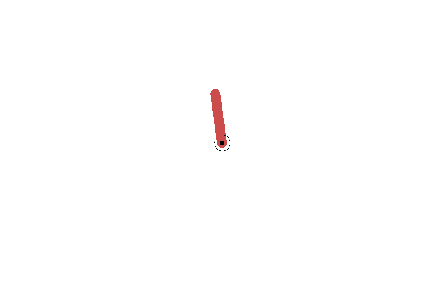
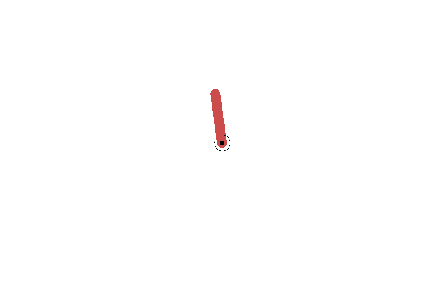
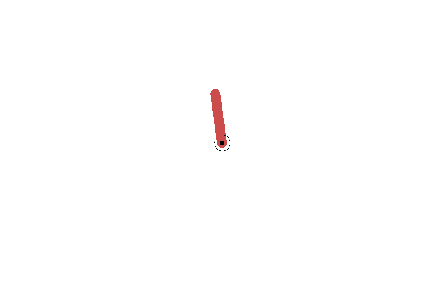
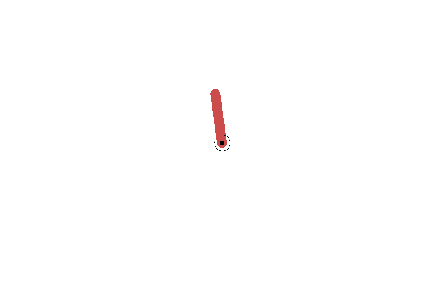
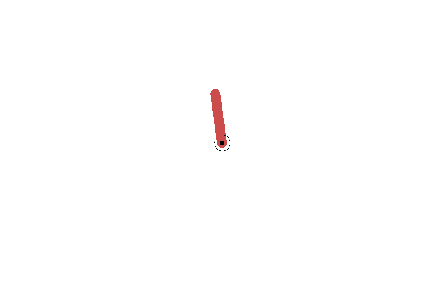
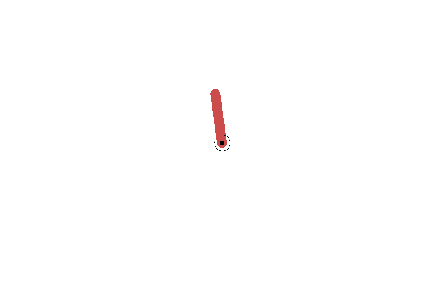
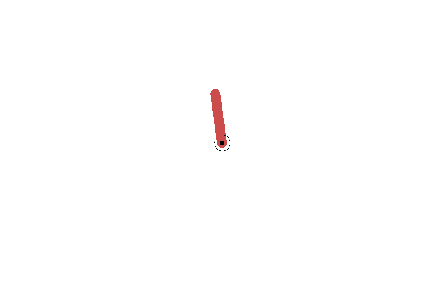
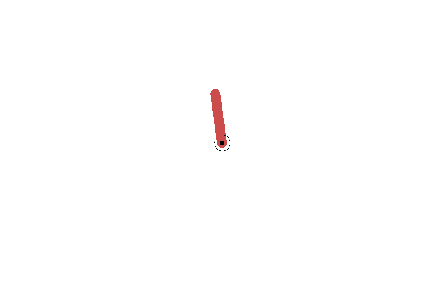
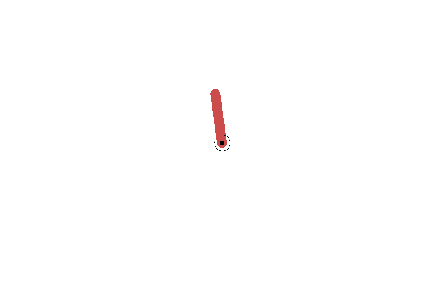
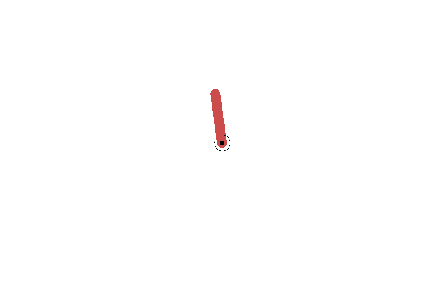
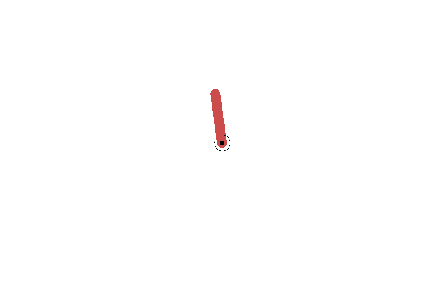
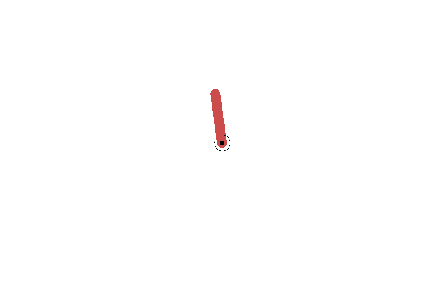
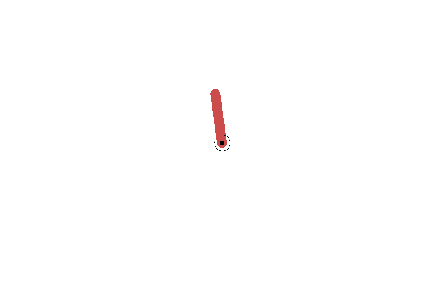
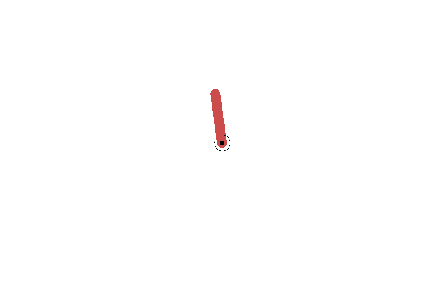
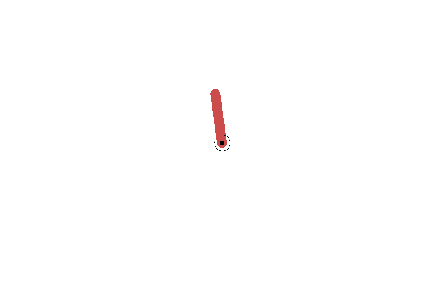
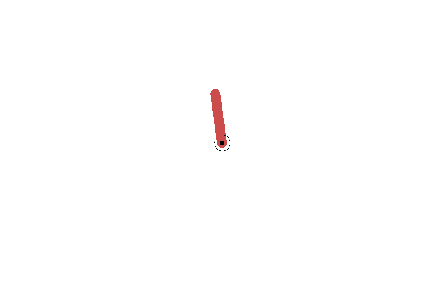
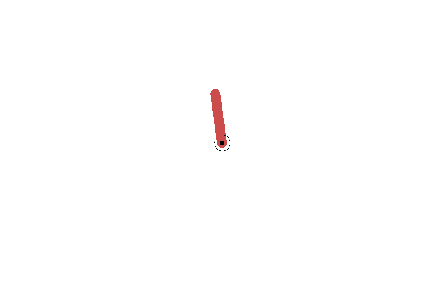
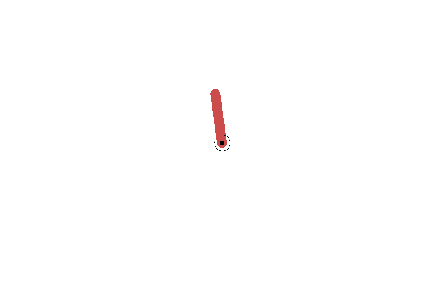
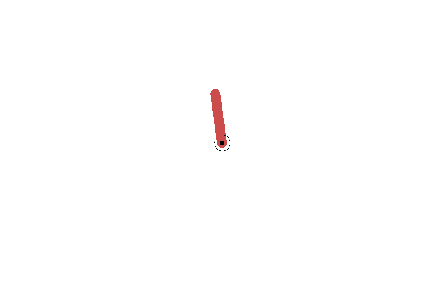
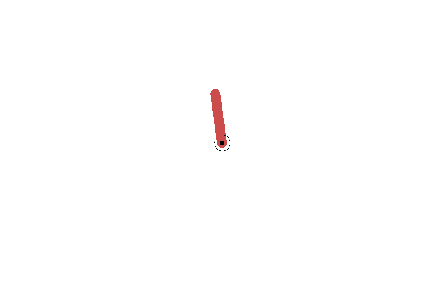
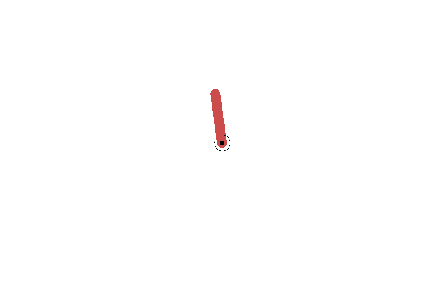
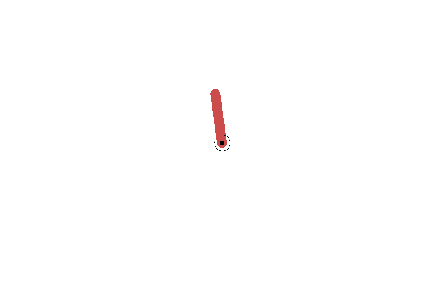
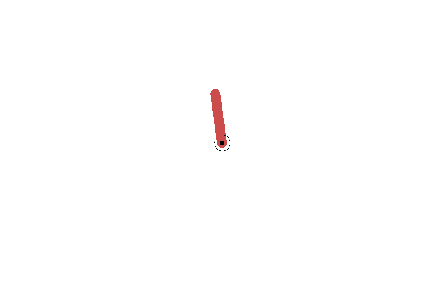
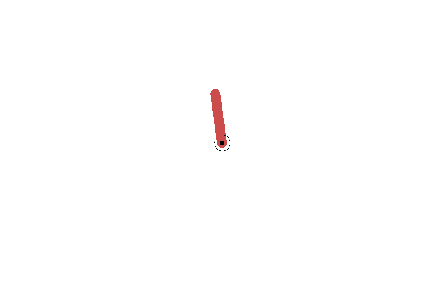
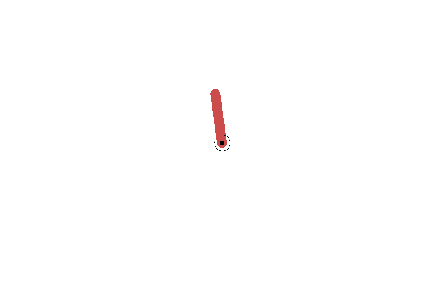
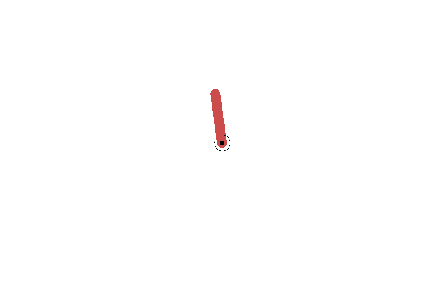
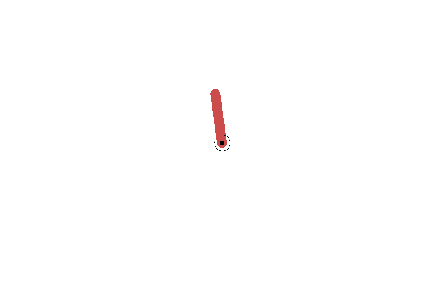
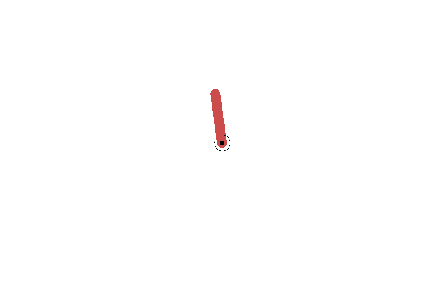
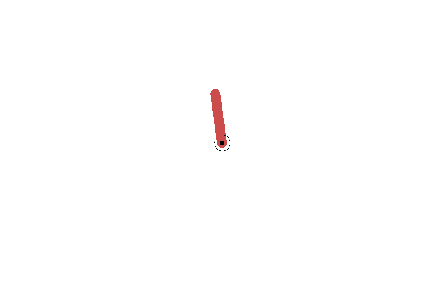
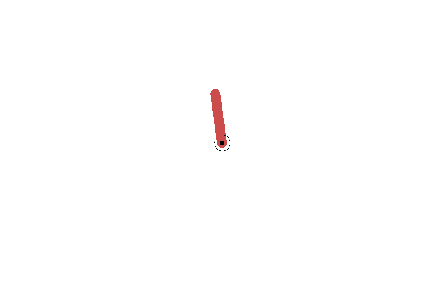
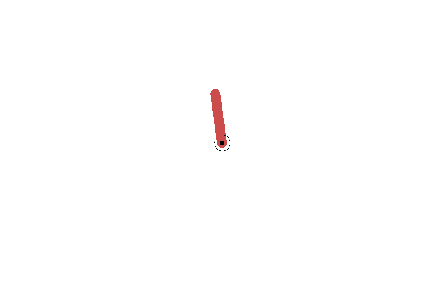
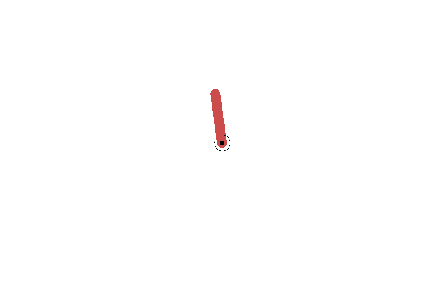
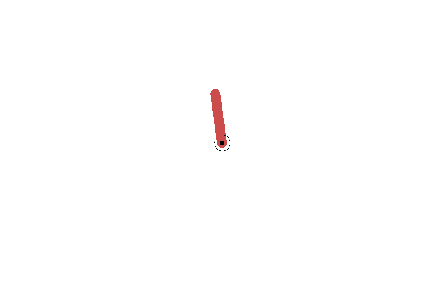
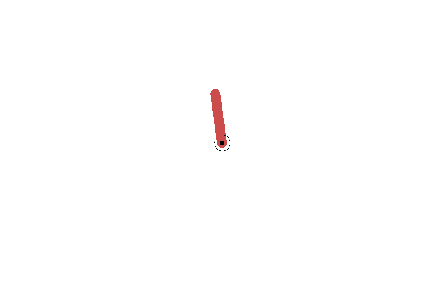
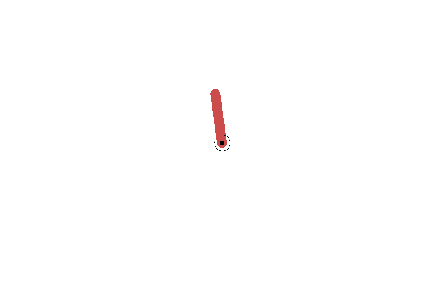
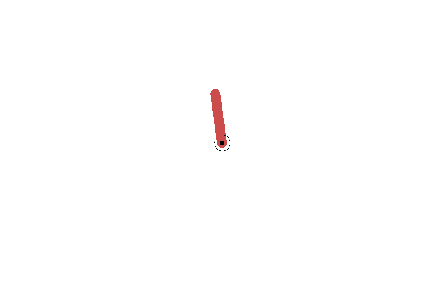
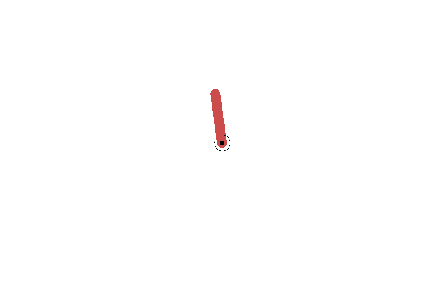
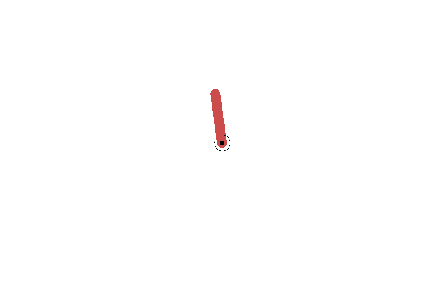
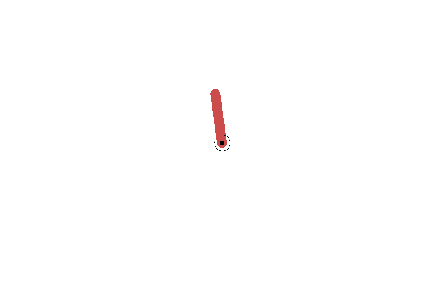
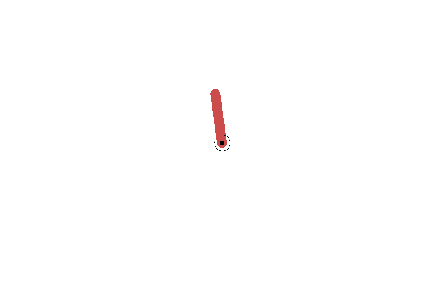
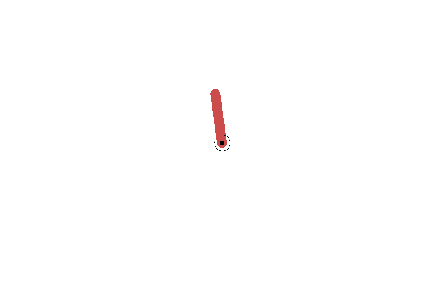
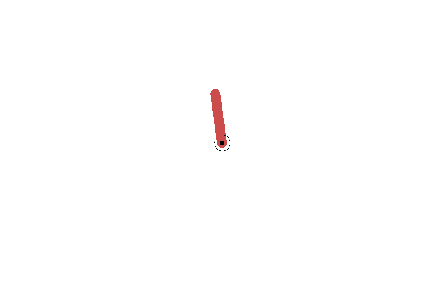
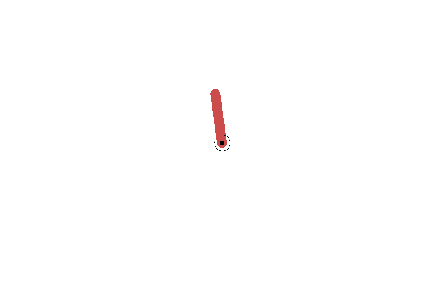
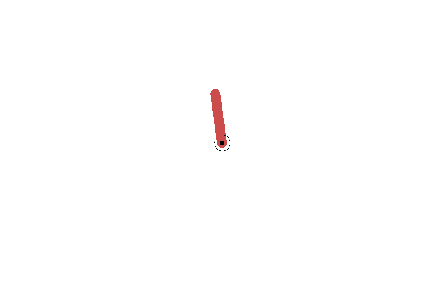
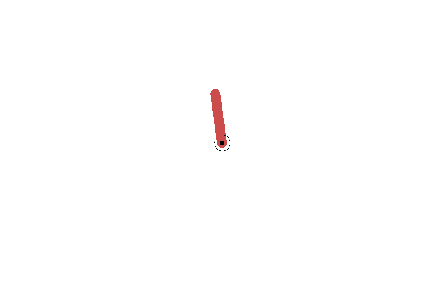
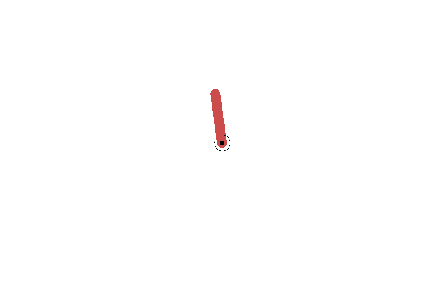
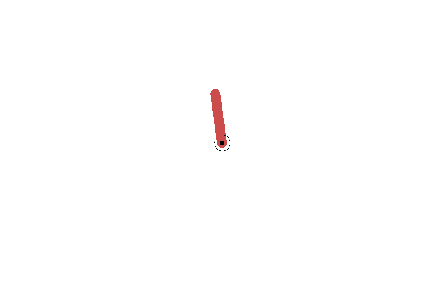
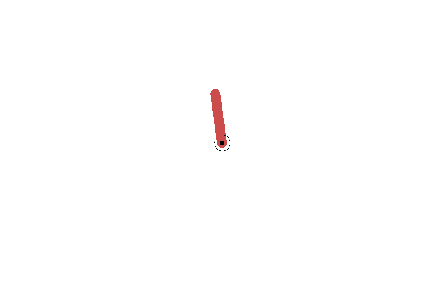
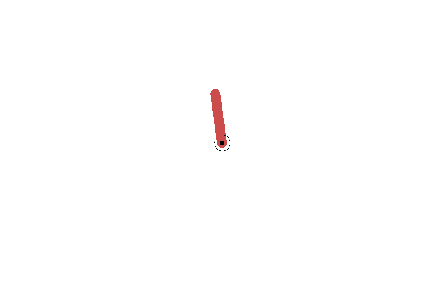
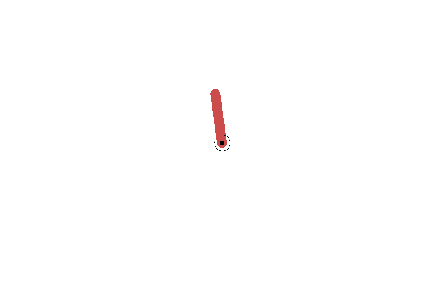
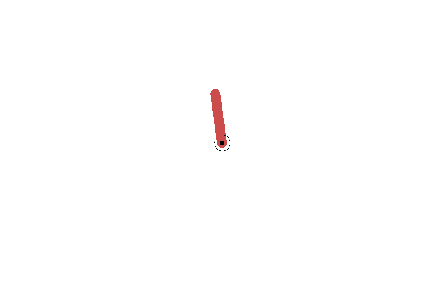
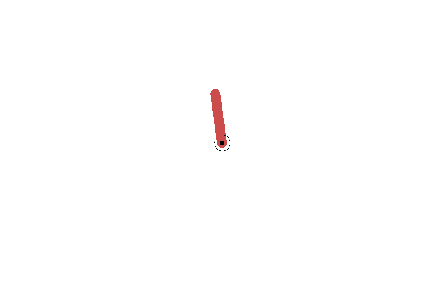
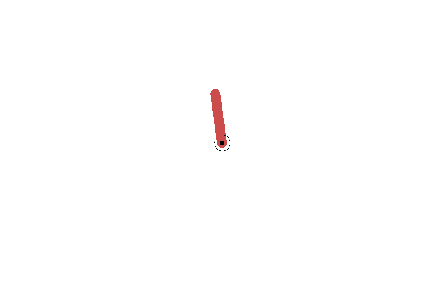
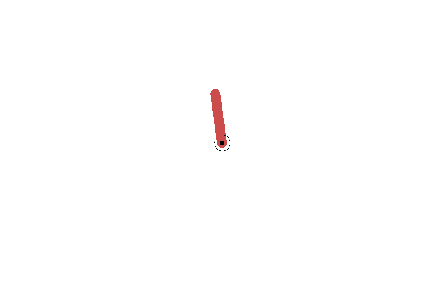
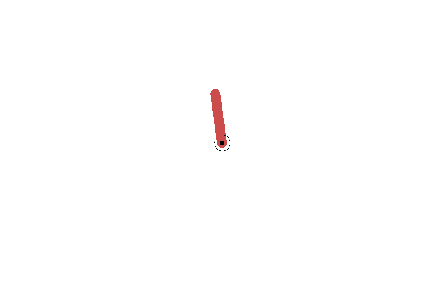
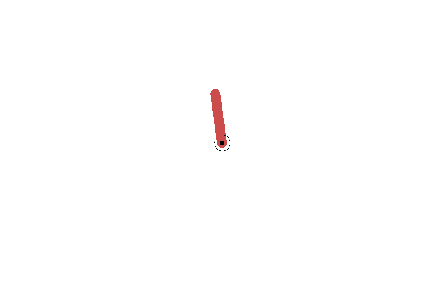
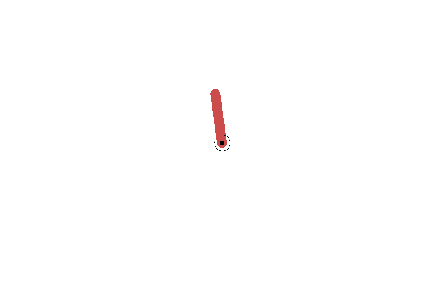
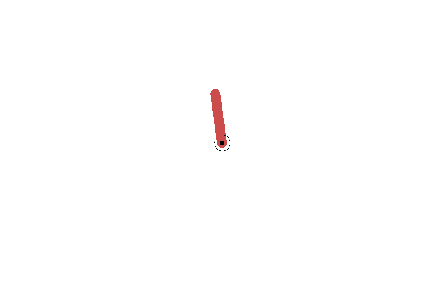
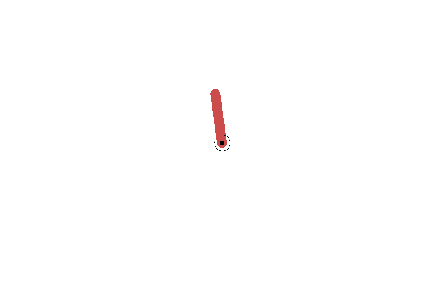
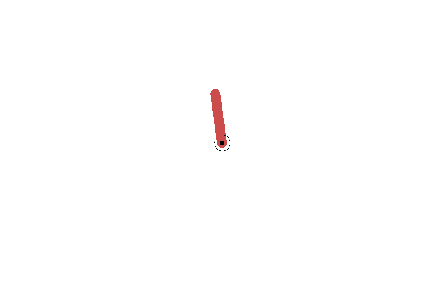
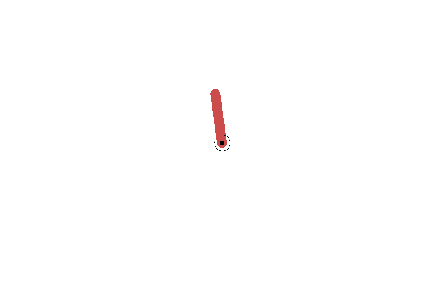
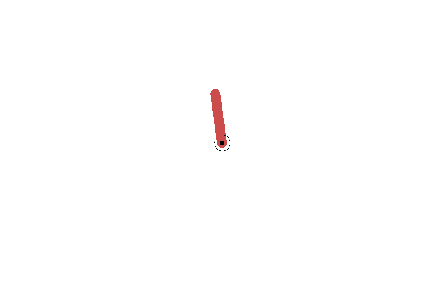
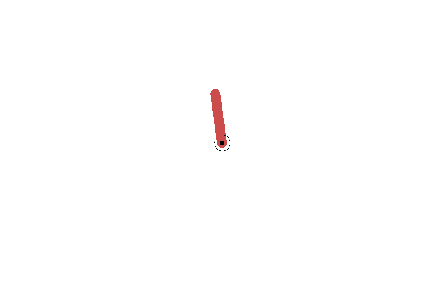
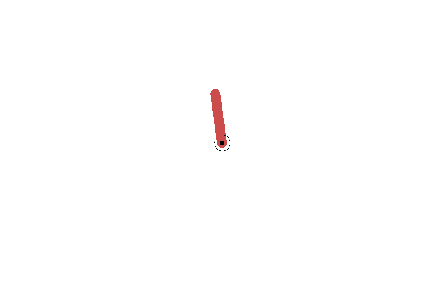
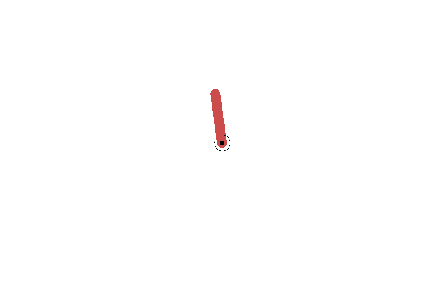
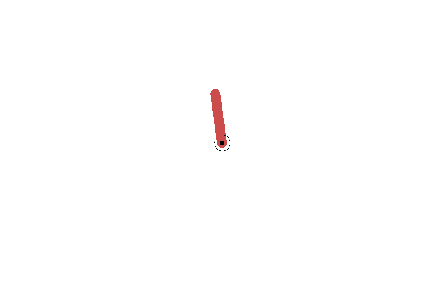
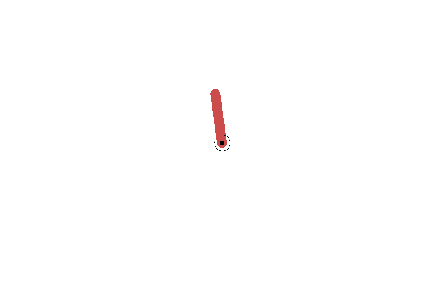
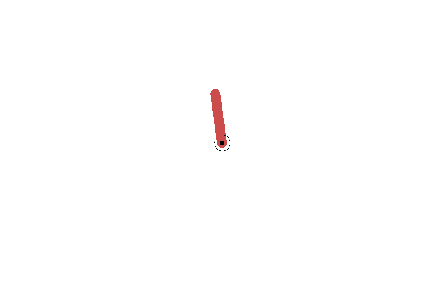
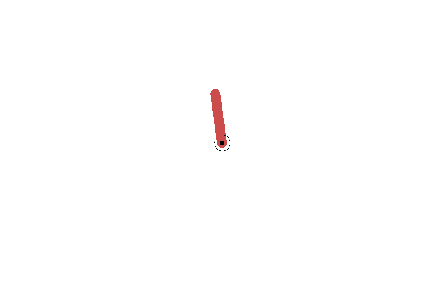
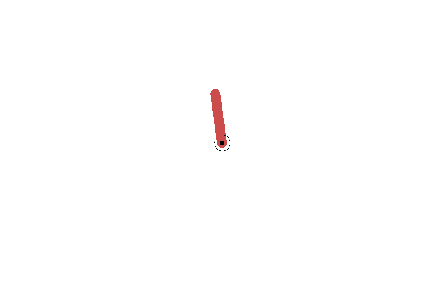
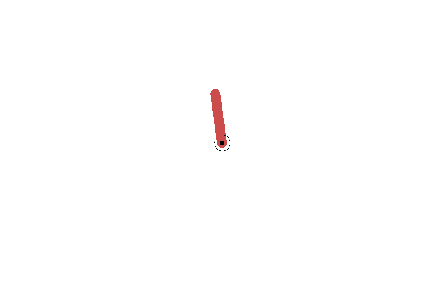
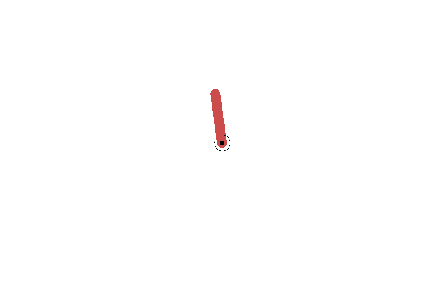
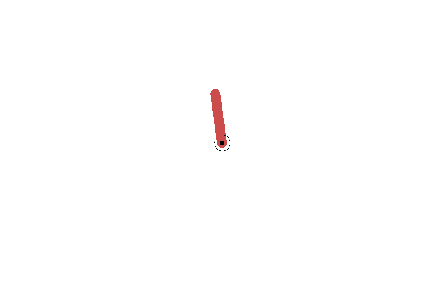
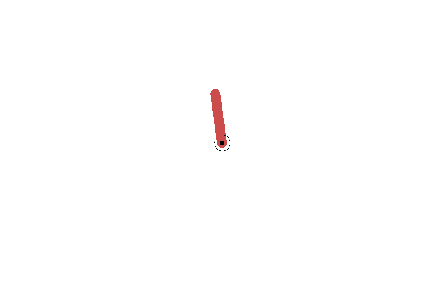
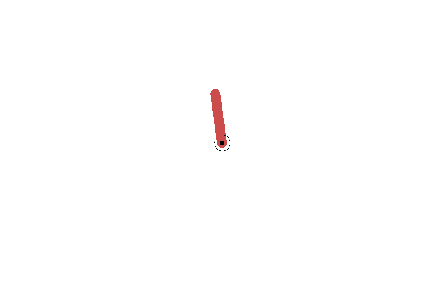
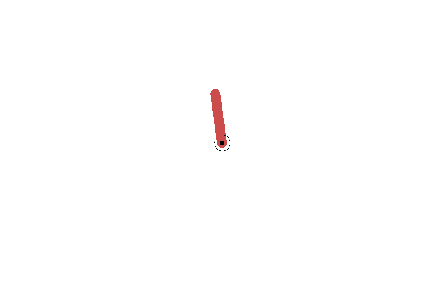
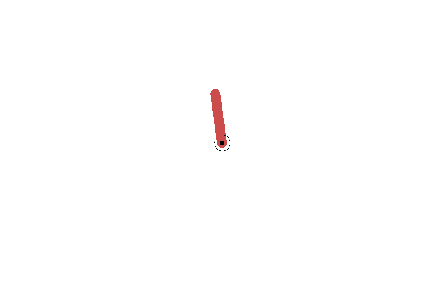
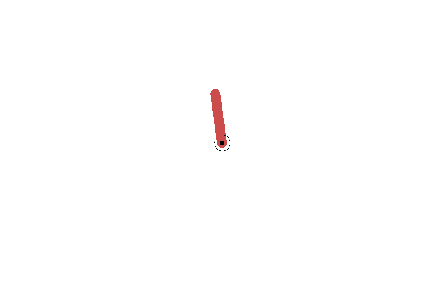
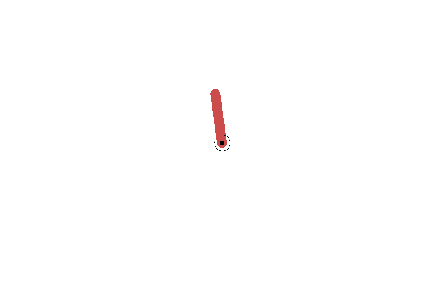

In [6]:
env = gym.make(envname)
obs = env.reset()
obs = np.reshape(obs, [1, -1])
total_reward = 0
frames = []
for t in range(10000):
    # Render into buffer. 
    frames.append(env.render(mode='rgb_array'))
    nz_obs = (obs - demo_obs_mean) / demo_obs_std
    action = gp.predict(nz_obs)
    obs, reward, done, info = env.step(action)
    obs = np.reshape(obs, [1, -1])
    total_reward += reward
    if done:
        break
env.close()
print('Total Reward : %.2f'%total_reward)
display_frames_as_gif(frames)